<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Evaluation-of-metadata-predictions" data-toc-modified-id="Evaluation-of-metadata-predictions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Evaluation of metadata predictions</a></span><ul class="toc-item"><li><span><a href="#Set-up" data-toc-modified-id="Set-up-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Set-up</a></span><ul class="toc-item"><li><span><a href="#Load-necessary-packages" data-toc-modified-id="Load-necessary-packages-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Load necessary packages</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><span><a href="#Load-embedding-model" data-toc-modified-id="Load-embedding-model-1.1.2.1"><span class="toc-item-num">1.1.2.1&nbsp;&nbsp;</span>Load embedding model</a></span></li><li><span><a href="#Create-dataframe" data-toc-modified-id="Create-dataframe-1.1.2.2"><span class="toc-item-num">1.1.2.2&nbsp;&nbsp;</span>Create dataframe</a></span></li></ul></li></ul></li><li><span><a href="#Prediction-performance" data-toc-modified-id="Prediction-performance-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Prediction performance</a></span><ul class="toc-item"><li><span><a href="#Overall-prediction-stats" data-toc-modified-id="Overall-prediction-stats-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Overall prediction stats</a></span></li><li><span><a href="#Exact-matches" data-toc-modified-id="Exact-matches-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Exact matches</a></span></li><li><span><a href="#Contained-within" data-toc-modified-id="Contained-within-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Contained within</a></span></li><li><span><a href="#Cosine-similarity" data-toc-modified-id="Cosine-similarity-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Cosine similarity</a></span><ul class="toc-item"><li><span><a href="#BLEU-scoring" data-toc-modified-id="BLEU-scoring-1.2.4.1"><span class="toc-item-num">1.2.4.1&nbsp;&nbsp;</span>BLEU scoring</a></span></li><li><span><a href="#Levenshtein-distance" data-toc-modified-id="Levenshtein-distance-1.2.4.2"><span class="toc-item-num">1.2.4.2&nbsp;&nbsp;</span>Levenshtein distance</a></span></li></ul></li></ul></li><li><span><a href="#Examples-of-misses?" data-toc-modified-id="Examples-of-misses?-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Examples of misses?</a></span></li></ul></li></ul></div>

# Evaluation of metadata predictions
Adam Klie<br>
12/08/2019<br>
Script to evaluate predictions

## Set-up

### Load necessary packages

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import Levenshtein

from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


### Load data

#### Load embedding model

In [2]:
nlp = spacy.load('../data/wikipedia-pubmed-and-PMC-w2v')

/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


#### Create dataframe

In [3]:
model_iter = '11_class'

In [4]:
grouping = pd.read_csv('../results/embedding/{model}/entity_merging.csv'.format(model=model_iter), index_col=0)

In [5]:
groups = grouping[grouping["I"] == 0]["GroupName"].values

In [6]:
import warnings
warnings.filterwarnings('ignore')
validation_data_count = {}
merged = pd.DataFrame()
total_count = 0
for group in groups:
    group_dir = group.replace(' ', '_')
    group_dir = group_dir.replace('/', '_')
    #if group == "Platform":
    #    continue
    predicted_df = pd.read_pickle(
    '../results/prediction/{mymodel}/{myclass}_prediction.pickle'.format(mymodel = model_iter, 
                                                                          myclass = group_dir))
    class_validation = pd.read_pickle(
    '../results/validation/{mymodel}/{myclass}_validation_values.pickle'.format(mymodel = model_iter, 
                                                                                myclass = group_dir))
    validation_data = pd.read_pickle(
    '../results/validation/{mymodel}/{myclass}_validation_set.pickle'.format(mymodel = model_iter, 
                                                                             myclass = group_dir))
    class_df = predicted_df[predicted_df['predicted'] == group]
    print(group, ":", validation_data.shape[0], ",", class_df.shape[0])
    validation_data_count[group] = validation_data.shape[0]
    tmp_df = class_validation.loc[class_df['srs'].values]
    tmp_df = tmp_df.loc[~tmp_df.index.duplicated(keep = 'first')]
    class_df['actual'] = tmp_df.loc[class_df['srs'].values]['value'].values
    merged = pd.concat([merged, class_df], axis=0)
    total_count = total_count + validation_data.shape[0]

Species : 1000 , 855
Strain : 1000 , 295
Cell type : 702 , 144
Genotype : 595 , 130
Condition/Disease : 122 , 23
Tissue : 1000 , 237
Sex : 190 , 4
Age : 1000 , 224
Data type : 78 , 12
Platform : 275 , 30
Protocol : 18 , 0


## Prediction performance

### Overall prediction stats

In [7]:
predicted_count = merged.shape[0]
print(('%d/%d (%.2f%%) predicted' % 
       (predicted_count, total_count, predicted_count/total_count*100)))

1954/5980 (32.68%) predicted


In [8]:
merged["predicted"].value_counts()

Species              855
Strain               295
Tissue               237
Age                  224
Cell type            144
Genotype             130
Platform              30
Condition/Disease     23
Data type             12
Sex                    4
Name: predicted, dtype: int64

In [9]:
# missing_df = class_validation[~class_validation.index.isin(class_df['srs'].values)]
# missing = validation_data[~validation_data.index.get_level_values(0).isin(class_df['srs'].values)]
# if missing_df.shape[0] == len(missing):  # if there are not duplicate srs predictions
#     missing_df['TITLE'] = missing.values

In [10]:
# missing_df.to_csv(
#     '../results/{model}/predictions/{myclass}_missing.csv'.format(model = model_iter, myclass = predicted_class))

### Exact matches

In [11]:
merged["exact_match"] = merged['token'] == merged['actual']

In [12]:
num_correct = merged["exact_match"].sum()
print(('%d/%d (%.2f%%) exact matches' % 
       (num_correct, predicted_count, num_correct/predicted_count*100)))

448/1954 (22.93%) exact matches


In [13]:
class_exact = merged.groupby(['predicted', 'exact_match']).size().reset_index().pivot(index='predicted', 
                                                                                      columns='exact_match')
class_exact

0       
exact_match        False  True 
predicted                      
Age                186.0   38.0
Cell type          142.0    2.0
Condition/Disease   14.0    9.0
Data type           12.0    NaN
Genotype           109.0   21.0
Platform            30.0    NaN
Sex                  4.0    NaN
Species            529.0  326.0
Strain             273.0   22.0
Tissue             207.0   30.0

In [14]:
merged.groupby('exact_match').mean()["score"]

exact_match
False    0.406085
True     0.530445
Name: score, dtype: float32

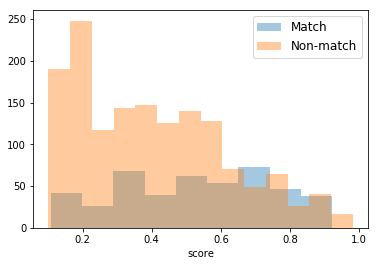

In [15]:
sns.distplot(merged[merged['exact_match'] == True]['score'], label='Match', kde=False)
sns.distplot(merged[merged['exact_match'] == False]['score'], label='Non-match', kde=False)
plt.legend(prop={'size': 12})

In [16]:
# exact_correct_df.to_csv(
#     '../results/{model}/predictions/{myclass}_correct.csv'.format(model = model_iter, myclass = predicted_class))
# exact_incorrect_df.to_csv(
#     '../results/{model}/predictions/{myclass}_incorrect.csv'.format(model = model_iter, myclass = predicted_class))

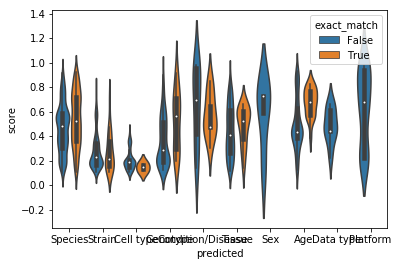

In [17]:
ax = sns.violinplot(x='predicted', y='score', data=merged, hue='exact_match')

### Contained within

In [18]:
def within(x):
    if (x["actual"] in x['token']) or (x['token'] in x["actual"]):
        return True
    else:
        return False

In [19]:
merged['within'] = merged.apply(within, axis=1)
count = merged['within'].sum()

In [20]:
print(('%d/%d (%.2f%%) of predicted contained in actual' % 
       (count, predicted_count, count/predicted_count*100)))

1264/1954 (64.69%) of predicted contained in actual


In [21]:
class_contain = merged.groupby(['predicted', 'within']).size().reset_index().pivot(index='predicted', 
                                                                                      columns='within')
class_contain.columns = ["non-match", "match"]
class_contain["fraction_match"] = class_contain["match"]/class_contain.sum(axis=1)

In [22]:
class_contain

,non-match,match,fraction_match
predicted,,,
Age,160.0,64.0,0.285714
Cell type,98.0,46.0,0.319444
Condition/Disease,9.0,14.0,0.608696
Data type,12.0,NaN,NaN
Genotype,81.0,49.0,0.376923
Platform,21.0,9.0,0.300000
Sex,3.0,1.0,0.250000
Species,103.0,752.0,0.879532
Strain,54.0,241.0,0.816949


### Cosine similarity

In [23]:
predicted_docs = nlp.pipe(merged['token'].tolist())
predicted_vectors = np.array([doc.vector for doc in predicted_docs])

actual_docs = nlp.pipe(merged['actual'].tolist())
actual_vectors = np.array([doc.vector for doc in actual_docs])

In [24]:
similarities = []
for i in range(len(predicted_vectors)):
    cosine_sim = cosine_similarity(predicted_vectors[i].reshape(1,200), actual_vectors[i].reshape(1,200))
    similarities.append(float(cosine_sim))

In [25]:
merged["cosine_similarity"] = similarities

(array([  8., 316.,  95.,  42.,  71.,  49.,  79., 136., 225., 933.]),
 array([-0.13195045, -0.01875538,  0.09443969,  0.20763475,  0.32082982,
         0.43402489,  0.54721996,  0.66041503,  0.7736101 ,  0.88680517,
         1.00000024]),
 <a list of 10 Patch objects>)

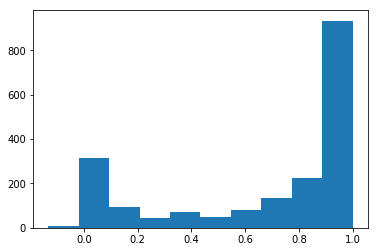

In [26]:
plt.hist(merged['cosine_similarity'])

In [27]:
sim_threshold = 0.8
merged["cosine_match"] = merged['cosine_similarity'].values > sim_threshold
num_sim = merged["cosine_match"].sum()

In [28]:
print(('%d/%d (%.2f%%) Predicted with cosine similarity greater than %.1f\n' 
                     % (num_sim, predicted_count, num_sim/predicted_count*100, sim_threshold)))

1112/1954 (56.91%) Predicted with cosine similarity greater than 0.8



In [29]:
class_cosine = merged.groupby(['predicted', 'cosine_match']).size().reset_index().pivot(index='predicted', 
                                                                                        columns='cosine_match')
class_cosine.columns = ["non-match", "match"]
class_cosine["fraction_match"] = class_cosine["match"]/class_cosine.sum(axis=1)

In [30]:
class_cosine

,non-match,match,fraction_match
predicted,,,
Age,153.0,71.0,0.316964
Cell type,88.0,56.0,0.388889
Condition/Disease,3.0,20.0,0.869565
Data type,10.0,2.0,0.166667
Genotype,84.0,46.0,0.353846
Platform,21.0,9.0,0.300000
Sex,NaN,4.0,1.000000
Species,68.0,787.0,0.920468
Strain,264.0,31.0,0.105085


In [31]:
title_counts = pd.DataFrame(pd.Series(validation_data_count), columns=['titles'])

In [32]:
class_contain

,non-match,match,fraction_match
predicted,,,
Age,160.0,64.0,0.285714
Cell type,98.0,46.0,0.319444
Condition/Disease,9.0,14.0,0.608696
Data type,12.0,NaN,NaN
Genotype,81.0,49.0,0.376923
Platform,21.0,9.0,0.300000
Sex,3.0,1.0,0.250000
Species,103.0,752.0,0.879532
Strain,54.0,241.0,0.816949


In [33]:
table1 = class_cosine.merge(pd.DataFrame(merged["predicted"].value_counts()), left_index=True, right_index=True)
table1 = table1.merge(title_counts, left_index=True, right_index=True)
table1 = table1.merge(class_contain, left_index=True, right_index=True, suffixes=['_cosine', '_contain'])

In [34]:
table1["fraction_predicted"] = table1['predicted']/table1['titles']

In [36]:
table1 = table1[['titles', 'predicted', 'fraction_predicted', 
        'match_cosine', 'fraction_match_cosine', 'match_contain', 'fraction_match_contain']]

In [37]:
table1['percent_correct'] = table1[["fraction_match_cosine", "fraction_match_contain"]].max(axis=1)

In [38]:
table1

,titles,predicted,fraction_predicted,match_cosine,fraction_match_cosine,match_contain,fraction_match_contain,percent_correct
Age,1000,224,0.224000,71.0,0.316964,64.0,0.285714,0.316964
Cell type,702,144,0.205128,56.0,0.388889,46.0,0.319444,0.388889
Condition/Disease,122,23,0.188525,20.0,0.869565,14.0,0.608696,0.869565
Data type,78,12,0.153846,2.0,0.166667,NaN,NaN,0.166667
Genotype,595,130,0.218487,46.0,0.353846,49.0,0.376923,0.376923
Platform,275,30,0.109091,9.0,0.300000,9.0,0.300000,0.300000
Sex,190,4,0.021053,4.0,1.000000,1.0,0.250000,1.000000
Species,1000,855,0.855000,787.0,0.920468,752.0,0.879532,0.920468
Strain,1000,295,0.295000,31.0,0.105085,241.0,0.816949,0.816949
Tissue,1000,237,0.237000,86.0,0.362869,88.0,0.371308,0.371308


In [39]:
table1.to_csv('../doc/tables/Table1.csv', index=True)

#### BLEU scoring

In [40]:
def bleu1(x):
    return sentence_bleu(x["predicted"], x["actual"], weights=(1, 0, 0, 0), smoothing_function=smoother.method1)

def bleu4(x):
    return sentence_bleu(x["predicted"], x["actual"], weights=(0, 0, 0, 1), smoothing_function=smoother.method1)

In [41]:
smoother = SmoothingFunction()
table1["BLUE1"] = table1.apply(bleu1, axis=1)
table1["BLUE4"] = table1.apply(bleu4, axis=1)

KeyError: ('actual', 'occurred at index Age')

#### Levenshtein distance

In [ ]:
def levenshtein(x):
    return Levenshtein.distance(x["predicted"], x["actual"])

In [ ]:
table1["levenshtein"] = table1.apply(levenshtein, axis=1)

## Examples of misses?

In [43]:
merged[merged["cosine_similarity"] < 0.8]

,srs,attribute,sentence_number,kthSrs,orig_text,n-gram_length,word_start,word_end,token,starting_char_pos,predicted,score,OverlapGroup,token_len,recovered_txt,actual,exact_match,within,cosine_similarity,cosine_match
2544,SRS2508701,TITLE,1,1078,32% Streptococcus mutans UA159 69,2,1,3,Streptococcus mutans,4,Species,0.375859,1635462,20,Streptococcus mutans,mixed sample,False,False,-0.008444,False
2536,SRS2508701,TITLE,2,1079,68% Lactobacillus casei 4646,2,1,3,Lactobacillus casei,4,Species,0.414886,1636978,19,Lactobacillus casei,mixed sample,False,False,0.068801,False
2535,SRS354304,TITLE,0,303,A cucumber genomic variation map reveals impac...,2,0,2,A cucumber,0,Species,0.173415,459786,10,A cucumber,Cucumis sativus,False,False,0.636063,False
2411,SRS002936,TITLE,0,927,Brucella abortus bv,2,0,2,Brucella abortus,0,Species,0.518422,1406383,16,Brucella abortus,Brucella abortus bv. 1 str. 2054#1021,False,True,0.791000,False
2403,ERS1473515,TITLE,0,1196,Bulk soils compared rhizosphere communities pl...,2,6,8,Saxifraga oppositifolia,50,Species,0.817979,1814456,23,Saxifraga oppositifolia,unidentified bacterium,False,False,0.156317,False
2400,ERS1230263,TITLE,1,1345,CBo1 isolated gut Bactrocera oleae,2,3,5,Bactrocera oleae,18,Species,0.874822,2040488,16,Bactrocera oleae,Chryseobacterium sp. 113(2015),False,False,0.192421,False
2356,DRS003378,TITLE,0,530,Chili pepper restorer line 121C anthers,2,0,2,Chili pepper,0,Species,0.155371,804125,12,Chili pepper,Capsicum annuum,False,False,0.576789,False
2288,ERS846263,TITLE,1,48,Ebolavirus surveillance using portable nanopor...,2,0,2,Ebolavirus surveillance,0,Species,0.246687,72923,23,Ebolavirus surveillance,Zaire ebolavirus,False,False,0.641300,False
2256,SRS1711448,TITLE,2,503,Endophytic isolate branches Citrus sinensis,2,3,5,Citrus sinensis,28,Species,0.473479,763157,15,Citrus sinensis,Curtobacterium sp. ER1/6,False,False,0.295182,False
2245,SRS588730,TITLE,0,240,Environmental/Metagenome sample subarctic root...,2,2,4,subarctic root,32,Species,0.782490,364184,14,subarctic root,Fungi,False,False,0.190062,False
